# Testing code for my 2.5D forward simulation and inversion using simpeg

In this file I define all the functions explicitly, which in the `.py` files I import from `functions.py` instead.

In [1]:
#imports

# SimPEG functionality
from simpeg.electromagnetics.static import resistivity as dc
from simpeg.utils import model_builder, download
from simpeg.utils.solver_utils import get_default_solver
from simpeg.utils.io_utils import read_dcip2d_ubc
from simpeg.utils.io_utils.io_utils_electromagnetics import write_dcip2d_ubc
from simpeg import (
    maps,
    data,
    data_misfit,
    regularization,
    optimization,
    inverse_problem,
    inversion,
    directives,
)
from simpeg.electromagnetics.static.utils.static_utils import (
    generate_dcip_sources_line,
    generate_survey_from_abmn_locations,
    pseudo_locations,
    plot_pseudosection,
    apparent_resistivity_from_voltage,
)

# Suppress the DefaultSolverWarning
import warnings
import simpeg.utils.solver_utils  # Ensure the module is imported
warnings.filterwarnings('ignore', category=simpeg.utils.solver_utils.DefaultSolverWarning)

# discretize functionality
from discretize import TreeMesh, TensorMesh
from discretize.utils import active_from_xyz


# Common Python functionality
import os
import numpy as np
from scipy.interpolate import interp1d
from scipy.spatial import cKDTree
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import tarfile

mpl.rcParams.update({"font.size": 14})  # default font size
cmap = mpl.cm.RdYlBu_r  # default colormap

### Read in the res2dinv file to define the survey layout and resistivity values, as well as getting electrode locations (topo)



There is the option to set `std_method` to either `"measured"` (uses data from the file) or `"constant"` which sets all points with a 5% error.

In [2]:
def haversine(lat1, lon1, lat2, lon2):
    """Compute Haversine distance between two lat/lon points."""
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    return 2 * 6371000 * np.arcsin(np.sqrt(a))

def create_topo(file_path, n_points):
    """
    Reads in topography data, interpolates the elevation over the new range.

    Parameters:
        file_path (str): Path to the input file.
        n_points (int): Number of points in the interpolated profile.

    Returns:
        np.ndarray: A 2-column NumPy array with [x_values, elevation].
    """
    # Load data from file (assuming tab or space delimiter, skipping header)
    data = np.loadtxt(file_path, skiprows=1, usecols=(1, 2, 3))

    # Extract latitude, longitude, and altitude
    lat, lon, alt = data[:, 0], data[:, 1], data[:, 2]

    # Compute cumulative distances along the track
    distances = np.zeros(len(lat))
    for i in range(1, len(lat)):
        distances[i] = distances[i - 1] + haversine(lat[i - 1], lon[i - 1], lat[i], lon[i])

    # Compute the new x positions based on electrode limits
    topo_x = np.linspace(distances[0], distances[-1], n_points)

    interp_func = interp1d(
        distances, 
        alt,
        kind="cubic",
        fill_value="extrapolate"
    )
    
    topo_z = interp_func(topo_x)

    # Combine into a 2D NumPy array
    topo_2d = np.column_stack((topo_x, topo_z))

    return topo_2d

In [3]:
def generate_dcdata_from_res2dinv_with_topo(file_path, topo_file_path=None, n_points=401, std_method="measured"):
    """
    Extracts electrode positions, resistivity and error data from a RES2DINV .dat file, adding in topography from the google earth profile
    and generates a survey using SimPEG's generate_survey_from_abmn_locations function.

    This function reads a resistivity survey file in RES2DINV format and extracts:
    - Electrode coordinates (X, Z) for each measurement
    - Apparent resistivity values (Ωm)
    - Measurement error percentages

    Chargeability data (if present) is ignored.

    Parameters:
    ----------
    file_path : str
        Path to the .dat file containing the resistivity survey data.
    topo_file_path : str
        Path to the .dat file containing the lat, long and alt along the profile
    std_method : str, optional
        "measured" to use the given uncertainty for each data point
        "constant" to use a constant percentage error for all points of 5% (default is "measured").

    Returns
    -------
    dc_data : SimPEG `data.Data` object containing the survey and resistivity values.
    topo_profile : np.array (n_points, 2) with equally spaced n_points and elevation of ground

    Example:
    -------
    >>> data = generate_dcdata_from_res2dinv("survey.dat")
    >>> print(data[0])
    {'electrodes': [(10.0, 0.0), (40.0, 0.0), (20.0, 0.0), (30.0, 0.0)],
     'resistivity': 82.437,
     'error': 12.183}
    """
    with open(file_path, "r") as file:
        lines = file.readlines()

    num_data_points = int(lines[6].strip())  # Number of data points

    # Read the data section
    A = np.zeros((num_data_points, 2))
    B = np.zeros((num_data_points, 2))
    M = np.zeros((num_data_points, 2))
    N = np.zeros((num_data_points, 2))
    dobs = np.zeros(num_data_points)
    error = np.zeros(num_data_points)

    data_start_line = 12
    for i, line in enumerate(
        lines[data_start_line : data_start_line + num_data_points]
    ):
        values = line.strip().split()
        if len(values) >= 11:
            A[i] = [float(values[1]), float(values[2])]
            B[i] = [float(values[3]), float(values[4])]
            M[i] = [float(values[5]), float(values[6])]
            N[i] = [float(values[7]), float(values[8])]
            dobs[i] = float(values[9])  # Apparent resistivity
            error[i] = float(values[10])  # Error percentage

    # Store all arrays in a list for easy iteration
    arrays = [A, B, M, N]
    
    # If a topography profile is provided, match it to the electrode positions
    if topo_file_path is not None:
        topo_profile = create_topo(topo_file_path, n_points)  # Load topography data
        
        # Create KDTree for fast nearest-neighbor search
        tree = cKDTree(topo_profile[:, 0].reshape(-1, 1))
        
        # Assign nearest z-values to each array
        for arr in arrays:
            _, idx = tree.query(arr[:, 0].reshape(-1, 1))  # Find nearest x index
            arr[:, 1] = topo_profile[idx, 1]  # Assign corresponding z value
    
    # Compute the midpoint of all x-coordinates
    all_x_coords = np.concatenate([arr[:, 0] for arr in arrays])
    midpoint_electrodes = np.mean([np.min(all_x_coords), np.max(all_x_coords)])  # Equivalent to (min + max) / 2
    
    # Adjust x-coordinates
    for arr in arrays:
        arr[:, 0] -= midpoint_electrodes
    
    # Combine all electrodes into a single array and remove duplicates
    electrodes = np.unique(np.vstack(arrays), axis=0)
    
    # Generate the survey
    survey = generate_survey_from_abmn_locations(
        locations_a=A,
        locations_b=B,
        locations_m=M,
        locations_n=N,
        data_type="volt",
    )

    # Determine the standard deviation for the error
    if std_method == "measured":
        # Use relative_error: measured error percentages
        relative_error = np.abs(error) / 100  # Convert error to decimal percentage
        dc_data = data.Data(
            survey, dobs=dobs, noise_floor=1e-7, relative_error=relative_error
        )
    elif std_method == "constant":
        # Use relative_error with constant percentage (e.g., 5%)
        std = 1e-7 + 0.05 * np.abs(dobs)  # 5% constant error
        dc_data = data.Data(survey, dobs=dobs, standard_deviation=std)
    else:
        # Handle the case when an invalid `std_method` is passed
        warnings.warn("Invalid std_method. Defaulting to 'measured'.")
        relative_error = np.abs(error) / 100  # Default to measured error
        dc_data = data.Data(survey, dobs=dobs, relative_error=relative_error)

    #take midpoint off topo_profile
    if topo_file_path is None:
        topo_profile = np.c_[np.linspace(-midpoint_electrodes, midpoint_electrodes, n_points), np.zeros(n_points)]
    else:
        topo_profile[:,0] = np.linspace(-midpoint_electrodes, midpoint_electrodes, n_points)

    # Plot electrode positions
    plot_electrode_positions(topo_profile, electrodes)

    return dc_data, topo_profile


def plot_electrode_positions(topo, electrodes):
    """
    Plots all electrode positions as black dots along with the survey topography as a line.

    Parameters
    ----------
    topo : np.ndarray, shape (N, 2)
        Array of unique survey topography points [(x1, z1), (x2, z2), ...].
    electrodes : np.ndarray, shape (M, 2)
        Array of all electrode positions [(x1, z1), (x2, z2), ...].

    Returns
    -------
    None
    """
    plt.figure(figsize=(8, 5))

    # Plot topography line
    sorted_topo = topo[np.argsort(topo[:, 0])]  # Sort by x-coordinates
    plt.plot(
        sorted_topo[:, 0],
        sorted_topo[:, 1],
        color="black",
        linestyle="-",
        linewidth=1.5,
        label="Topography",
    )

    # Plot electrodes as red dots
    plt.scatter(
        electrodes[:, 0],
        electrodes[:, 1],
        color="red",
        marker="o",
        s=20,
        label="Electrodes",
    )

    # Labels and formatting
    plt.xlabel("X Position (m)")
    plt.ylabel("Z Position (m)")
    plt.ylim([ np.min(electrodes[:,1])-20, np.max(electrodes[:,1])+20 ])
    plt.title("Electrode Positions with Topography")
    plt.legend()
    plt.grid(True)
    plt.gca().invert_yaxis()  # Invert Z-axis to show depth correctly

    # plt.show()


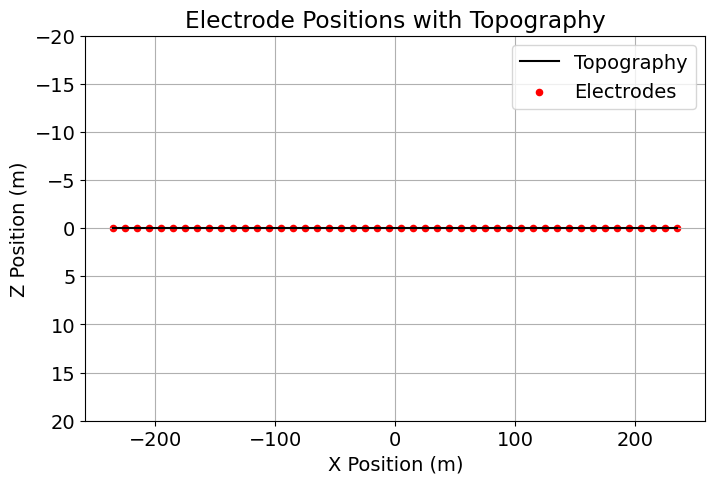

In [4]:
file_path = "data/Project4_Wenner_1.dat"
elev_filepath = 'data/Project4_Wenner_1_elev_profile.txt'
n_points = 401
voltage_data, topo_2d = generate_dcdata_from_res2dinv_with_topo(file_path, topo_file_path=None, n_points=401, std_method="constant")

## Plot pseudosections
- the normalised voltages (resistivities) for each electrode spacing
- the errors associated with each measurement (will depend if `"measured"` or `"constant"` used when data is read in.
- Apparent resistivity

Text(0.5, 1.0, 'Apparent Resistivity')

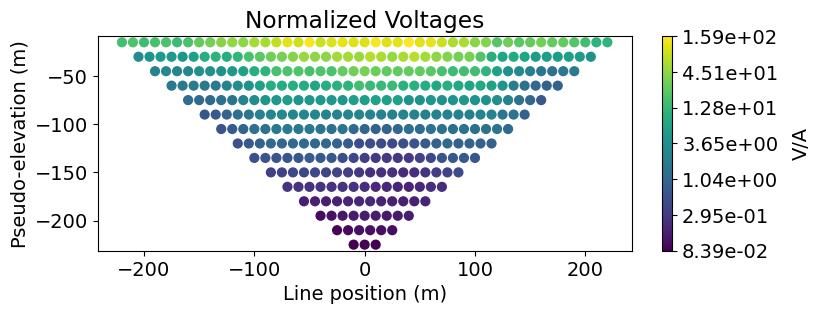

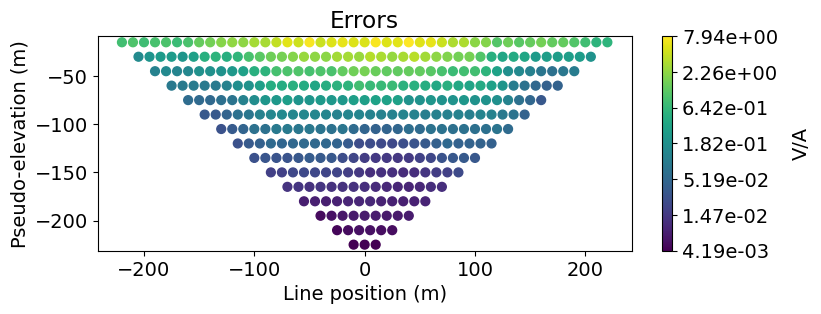

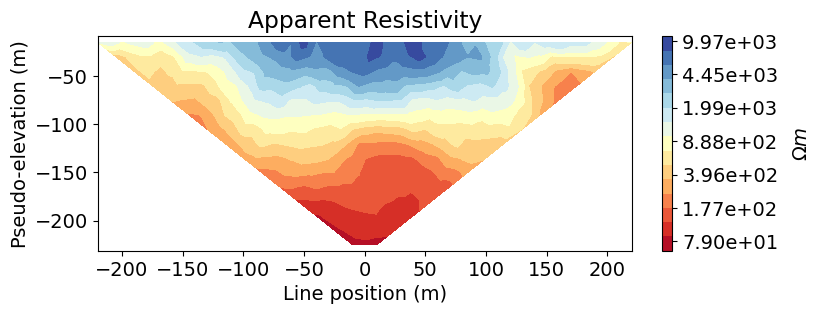

In [5]:
# Plot voltages pseudo-section
fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    voltage_data,
    plot_type="scatter",
    ax=ax1,
    scale="log",
    cbar_label="V/A",
    scatter_opts={"cmap": mpl.cm.viridis},
)
ax1.set_title("Normalized Voltages")

# Plot errors pseudo-section
fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    voltage_data.survey,
    voltage_data.standard_deviation,
    plot_type="scatter",
    ax=ax1,
    scale="log",
    cbar_label="V/A",
    scatter_opts={"cmap": mpl.cm.viridis},
)
ax1.set_title("Errors")

# Get apparent resistivities from volts and survey geometry
apparent_resistivities = apparent_resistivity_from_voltage(
    voltage_data.survey, voltage_data.dobs
)

# Plot apparent resistivity pseudo-section
fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    voltage_data.survey,
    apparent_resistivities,
    plot_type="contourf",
    ax=ax1,
    scale="log",
    cbar_label="$\Omega m$",
    mask_topography=True,
    contourf_opts={"levels": 20, "cmap": mpl.cm.RdYlBu},
)
ax1.set_title("Apparent Resistivity")


## Design a Tree Mesh

Uses discretize package. Electrode potential falls off as $r^{-3}$ so smaller cells at top and larger away from them. Considerations are as follows:

* No currents in the air, no padding upwards needed, top of mesh is top of topography.
* At least 2-3 cells between current electrodes. More accurate with smaller cells.
* Padding thickness at least 2-3 times the largest electrode spacing.
* Increase ain cell size shouldn't happen too abruptly, at least 4 cells thick before increasing.
* Finer discretization when topography is significant.


In [6]:
# Compute electrode spacing parameters
electrode_x = voltage_data.survey.unique_electrode_locations[:, 0]
max_spacing = np.max(electrode_x) - np.min(electrode_x)
min_spacing = np.min(np.diff(np.sort(electrode_x)))

cell_size = min_spacing / 10  # base cell width
dom_width_x = max_spacing * 8  # domain width x
dom_width_z = max_spacing * 8  # domain width z

# Compute number of base cells (rounded to power of 2)
nbcx = 2 ** int(np.round(np.log(dom_width_x / cell_size) / np.log(2.0)))
nbcz = 2 ** int(np.round(np.log(dom_width_z / cell_size) / np.log(2.0)))

# Define the base mesh with top at z = 0 m.
hx = [(cell_size, nbcx)]
hz = [(cell_size, nbcz)]
mesh = TreeMesh([hx, hz], x0="CN", diagonal_balance=True)

# Shift top to maximum topography
mesh.origin = mesh.origin + np.r_[0.0, topo_2d[:, 1].max()]

# Mesh refinement based on topography
mesh.refine_surface(
    topo_2d,
    padding_cells_by_level=[0, 0, 6, 8],
    finalize=False,
)

# Extract unique electrode locations.
unique_locations = voltage_data.survey.unique_electrode_locations

# Mesh refinement near electrodes.
mesh.refine_points(
    unique_locations, padding_cells_by_level=[10, 15, 8, 8], finalize=False
)

mesh.finalize()

In [7]:
# print properties

print("# of cells: {}".format(mesh.n_cells))  # Number of cells
print("# of x-faces: {}".format(mesh.n_faces_x))  # Number of x-faces
print("Origin: {}".format(mesh.origin))  # bottom-southewest corner
print("Max cell volume: {}".format(mesh.cell_volumes.max()))  # Largest cell size
print(mesh.cell_centers[0:5, :])  # Cell center locations

# of cells: 11566
# of x-faces: 11525
Origin: [-2048. -4096.]
Max cell volume: 1048576.0
[[-1536. -3584.]
 [ -512. -3584.]
 [-1536. -2560.]
 [ -512. -2560.]
 [  512. -3584.]]


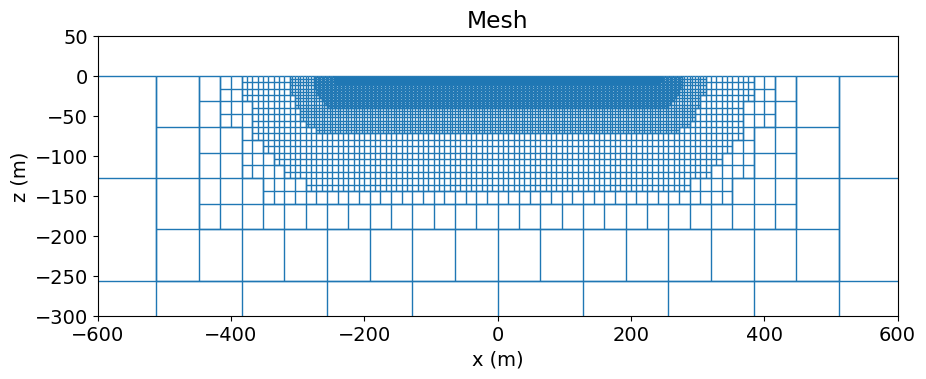

In [8]:
# plot mesh

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_axes([0.14, 0.17, 0.8, 0.7])
mesh.plot_grid(ax=ax1, linewidth=1)
ax1.grid(False)
ax1.set_xlim(-600, 600)
ax1.set_ylim(np.max(topo_2d[:,1]) - 300, np.max(topo_2d[:,1])+50)
ax1.set_title("Mesh")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

plt.show()


## Or alternatively, design a tensor mesh

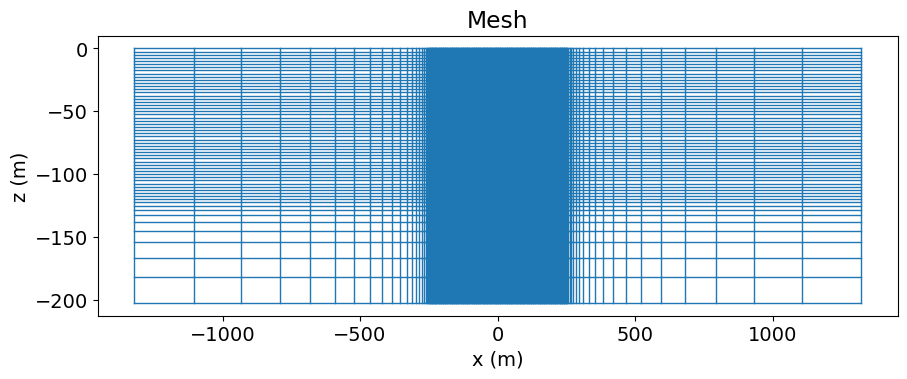

In [9]:
ncx = 200  # number of core mesh cells in x
ncy = 50  # number of core mesh cells in y
dx = 2.5  # base cell width x
dy = 2.5  # base cell width y
npad_x = 20  # number of padding cells in x
npad_y = 8  # number of padding cells in y
exp_x = 1.25  # expansion rate of padding cells in x
exp_y = 1.3  # expansion rate of padding cells in y

# Use a list of tuples to define cell widths in each direction. Each tuple
# contains the cell width, number of cells and the expansion factor. A
# negative sign is used to indicate an interval where cells widths go
# from largest to smallest.
hx = [(dx, npad_x, -exp_x), (dx, ncx), (dx, npad_x, exp_x)]
hy = [(dy, npad_y, -exp_y), (dy, ncy)]

# We can use flags 'C', '0' and 'N' to shift the xyz position of the mesh
# relative to the origin
mesh = TensorMesh([hx, hy], x0="CN")

# x0 = np.min(electrode_pos[:, 0]) - dom_width_x/2
# z0 = np.min(electrode_pos[:, 1])- dom_width_z

# mesh = TensorMesh([hx, hz], x0=[x0, z0])
# # Shift vertically to top same as maximum topography
# mesh.origin += np.r_[0.0, topo_2d[:,1].max()]
# # plot mesh

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_axes([0.14, 0.17, 0.8, 0.7])
mesh.plot_grid(ax=ax1, linewidth=1)
ax1.grid(False)
# ax1.set_xlim(-500, 500)
# ax1.set_ylim(np.max(topo_2d[:,1]) - 400, np.max(topo_2d[:,1])+50)
ax1.set_title("Mesh")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

plt.show()

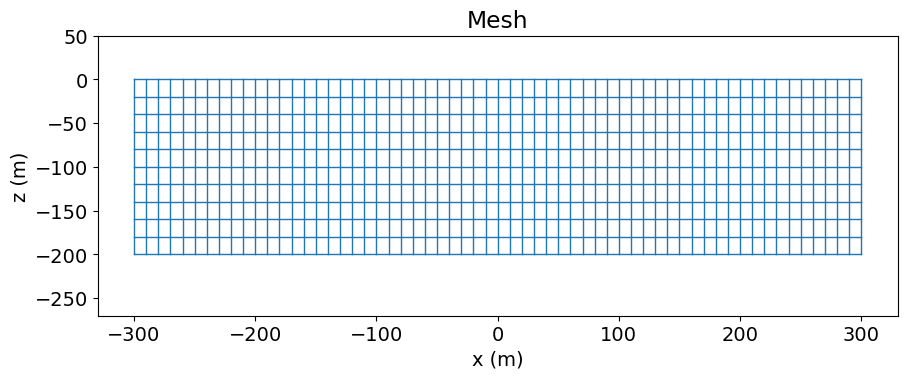

In [10]:
ncx = 60  # number of core mesh cells in x
ncy = 10  # number of core mesh cells in y
dx = 10  # base cell width x
dy = 20  # base cell width y
npad_x = 0  # number of padding cells in x
npad_y = 0  # number of padding cells in y
exp_x = 1.25  # expansion rate of padding cells in x
exp_y = 1.3  # expansion rate of padding cells in y

# Use a list of tuples to define cell widths in each direction. Each tuple
# contains the cell width, number of cells and the expansion factor. A
# negative sign is used to indicate an interval where cells widths go
# from largest to smallest.
hx = [(dx, npad_x, -exp_x), (dx, ncx), (dx, npad_x, exp_x)]
hy = [(dy, npad_y, -exp_y), (dy, ncy)]

# We can use flags 'C', '0' and 'N' to shift the xyz position of the mesh
# relative to the origin
mesh = TensorMesh([hx, hy], x0="CN")

# x0 = np.min(electrode_pos[:, 0]) - dom_width_x/2
# z0 = np.min(electrode_pos[:, 1])- dom_width_z

# mesh = TensorMesh([hx, hz], x0=[x0, z0])
# # Shift vertically to top same as maximum topography
# mesh.origin += np.r_[0.0, topo_2d[:,1].max()]
# # plot mesh

fig = plt.figure(figsize=(10, 4))
ax1 = fig.add_axes([0.14, 0.17, 0.8, 0.7])
mesh.plot_grid(ax=ax1, linewidth=1)
ax1.grid(False)
# ax1.set_xlim(-500, 500)
ax1.set_ylim(-270, np.max(topo_2d[:,1])+50)
ax1.set_title("Mesh")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

plt.show()

## Define active cells

i.e. set the cells above the surface as 'inactive cells' as their physical properties are fixed

In [11]:
# Indices of the active mesh cells from topography (e.g. cells below surface)
active_cells = active_from_xyz(mesh, topo_2d)

# number of active cells
n_active = np.sum(active_cells)

## Define and plot the model

Made a model that contains multiple layers (active layer, permafrost, bedrock). 

In future can add ice lenses or wedges here and see how well they are recovered

In [12]:
# define the model
air_res =  1e8
active_layer_res = 50
perma_layer_res = 600
bedrock_res = 10000

In [13]:
#use simpeg model builder functions to create the 3 layers
resistivity_model = model_builder.create_layers_model(
        mesh.cell_centers,
        layer_tops=np.array([0, -20]),
        # layer_values=np.array([active_layer_res, perma_layer_res]),
        layer_values=np.array([perma_layer_res, perma_layer_res]), #test all one
        # layer_values=np.array([bedrock_res, bedrock_res]), #test all one
)

conductivity_model = 1 / resistivity_model

# # Define log-resistivity model
log_resistivity_model = np.log(resistivity_model)

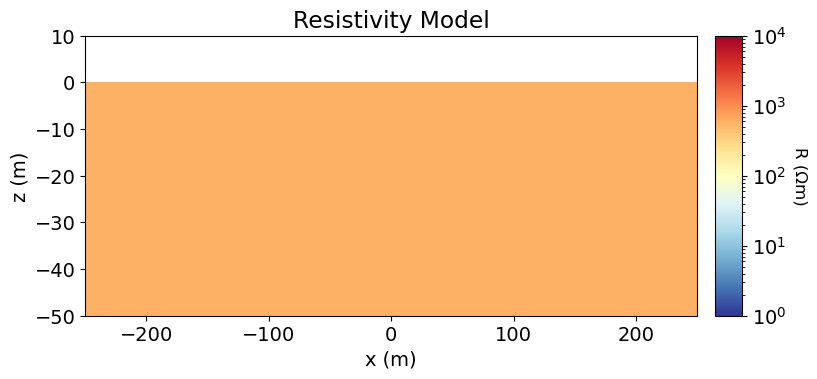

In [14]:
# Generate a mapping to ignore inactice cells in plot
plotting_map = maps.InjectActiveCells(mesh, active_cells, np.nan)

fig = plt.figure(figsize=(9, 4))

norm = LogNorm(vmin=1, vmax=1e4)

ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
mesh.plot_image(
    plotting_map * resistivity_model[active_cells],
    ax=ax1,
    grid=False,
    pcolor_opts={"norm": norm, "cmap": mpl.cm.RdYlBu_r},
)
ax1.set_xlim(-250, 250)
ax1.set_ylim(-50, 10)
ax1.set_title("Resistivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.84, 0.17, 0.03, 0.7])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label(r"R (Ωm)", rotation=270, labelpad=15, size=12)

In [15]:
# make sure the electrodes are mapped to being ON the surface, not below or especially not above
voltage_data.survey.drape_electrodes_on_topography(mesh, active_cells, option="top")

## Define Forward Simulation

Could also use Simulation2DCellCentered but Simulation2DNodel defines the electrical potential at nodes and is more well-suited for SURFACE resistivity data. Cell Centered good for borehole data.

Muse connect the simulation object to
* the survey
* the mesh
* the mapping from the model to the mesh
by setting each of these as a property of the simulation object.

In [16]:
# Conductivity map. Model parameters are conductivities for all active cells.
conductivity_map = maps.InjectActiveCells(mesh, active_cells, 1 / air_res)

# Resistivity map. Model parameters are log-resistivities for all active cells.
log_resistivity_map = maps.InjectActiveCells(
    mesh, active_cells, air_res
) * maps.ExpMap(nP=n_active)

## Define Simulation

In [17]:
#DC simulation for a conductivity model
voltage_simulation_con = dc.simulation_2d.Simulation2DNodal(
    mesh, survey=voltage_data.survey, sigmaMap=conductivity_map
)

# # # DC simulation for a log-resistivity model
voltage_simulation_res = dc.simulation_2d.Simulation2DNodal(
    mesh, survey=voltage_data.survey, rhoMap=log_resistivity_map
)

## Get predicted data

In [18]:
# conductivity model
dpred_con = voltage_simulation_con.dpred(conductivity_model)

# #log-resistivity model
dpred_res = voltage_simulation_res.dpred(log_resistivity_model)

In [19]:
print("MAX ABSOLUTE ERROR = {}".format(np.max(np.abs(dpred_con - dpred_res))))

MAX ABSOLUTE ERROR = 0.0


## Plot in pseudosection

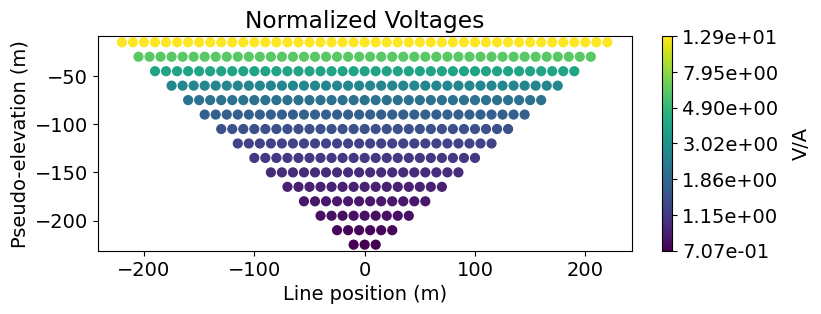

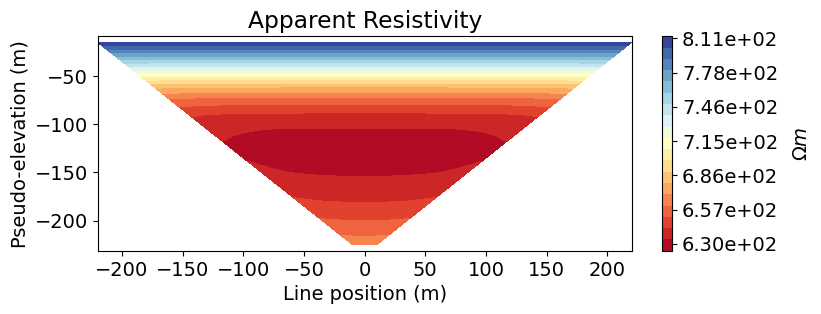

In [20]:
#choose which to plot
dpred = dpred_res


# Plot voltages pseudo-section
fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    voltage_data.survey,
    dobs=np.abs(dpred),
    plot_type="scatter",
    ax=ax1,
    scale="log",
    cbar_label="V/A",
    scatter_opts={"cmap": mpl.cm.viridis},
)
ax1.set_title("Normalized Voltages")
plt.show()

# Get apparent conductivities from volts and survey geometry
apparent_resistivity = apparent_resistivity_from_voltage(voltage_data.survey, dpred)

# Plot apparent conductivity pseudo-section
fig = plt.figure(figsize=(8, 2.75))
ax1 = fig.add_axes([0.1, 0.15, 0.75, 0.78])
plot_pseudosection(
    voltage_data.survey,
    apparent_resistivity,
    plot_type="contourf",
    ax=ax1,
    scale="log",
    cbar_label="$\Omega m$",
    mask_topography=True,
    contourf_opts={"levels": 20, "cmap": mpl.cm.RdYlBu},
    # clim = [1,10000],
)
ax1.set_title("Apparent Resistivity")
plt.show()

# INVERSION USING LOG RESISTIVITY MODEL

## Redefine simulation

StoreJ = True saves Jacobian

In [21]:
voltage_simulation = dc.simulation_2d.Simulation2DNodal(
    mesh, survey=voltage_data.survey, sigmaMap=log_resistivity_map, storeJ=True
)

## Starting model, median of the apparent resistivities

Can also use my fake model as the starting model at some point.

In [22]:
# Median apparent resistivity
median_resistivity = np.median(apparent_resistivity)

# Create starting model for log-resistivity
starting_resistivity_model = np.log(median_resistivity) * np.ones(n_active)

# Zero reference resistivity model
reference_resistivity_model = starting_resistivity_model.copy()

## Data misfit (L2 norm)

In [23]:
#put the dpred from the model into a simpeg data.Data object to use as observed starting data

std = 1e-7 + 0.05 * np.abs(dpred)  # 5% constant error
dc_data = data.Data(survey=voltage_data.survey, dobs=dpred, standard_deviation=std)

In [24]:
dmis_L2 = data_misfit.L2DataMisfit(simulation=voltage_simulation, data=dc_data)

## Regularization

In [35]:
cell_size = dx
reg_L2 = regularization.WeightedLeastSquares(
    mesh,
    active_cells=active_cells,
    alpha_s=cell_size**-2,
    alpha_x=1,
    alpha_y=1,
    reference_model=reference_resistivity_model,
    reference_model_in_smooth=False,
)


## Optimization

In [26]:
opt_L2 = optimization.InexactGaussNewton(
    maxIter=40, maxIterLS=20, maxIterCG=20, tolCG=1e-3
)

## Inverse problem

In [27]:
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)

## Inversion directives

In [28]:
sensitivity_weights = directives.UpdateSensitivityWeights(
    every_iteration=True, threshold_value=1e-2
)
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=10)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=2)
target_misfit = directives.TargetMisfit(chifact=2.0)

directives_list_L2 = [
    # sensitivity_weights,
    # update_jacobi,
    starting_beta,
    beta_schedule,
    target_misfit,
]

## Design and run inversion

In [32]:
solver_opts = {
    "pivot_tol": 1e-6,  # Lower pivot tolerance for better numerical stability
    "use_diagonal_precond": True  # Use simpler preconditioners for stability
}

In [33]:
# Here we combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Run the inversion
# recovered_model_L2 = inv_L2.run(np.log(0.01) * np.ones(n_param))
recovered_log_resistivity_model = inv_L2.run(starting_resistivity_model)

/Users/cara/opt/miniconda3/envs/eosc-556-project/lib/python3.11/site-packages/simpeg/directives/directives.py:325: UserWarning: InversionDirective BetaEstimate_ByEig has switched to a new inversion.
  d.inversion = i
/Users/cara/opt/miniconda3/envs/eosc-556-project/lib/python3.11/site-packages/simpeg/directives/directives.py:325: UserWarning: InversionDirective BetaSchedule has switched to a new inversion.
  d.inversion = i
/Users/cara/opt/miniconda3/envs/eosc-556-project/lib/python3.11/site-packages/simpeg/directives/directives.py:325: UserWarning: InversionDirective TargetMisfit has switched to a new inversion.
  d.inversion = i


The callback on the InexactGaussNewton Optimization was replaced.

Running inversion with SimPEG v0.23.0

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation2DNodal problem***
                        


/Users/cara/opt/miniconda3/envs/eosc-556-project/lib/python3.11/site-packages/pymatsolver/solvers.py:415: FutureWarning: In Future pymatsolver v0.4.0, passing a vector of shape (n, 1) to the solve method will return an array with shape (n, 1), instead of always returning a flattened array. This is to be consistent with numpy.linalg.solve broadcasting.
  return self.solve(val)


model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  7.31e-09  1.44e+05  0.00e+00  1.44e+05    5.95e-02      0              


MUMPSError: MUMPS failed with error -2.

## Plot misfit

In [ ]:
# Predicted data from recovered model
dpred = inv_prob_L2.dpred
dobs = voltage_data.dobs
std = voltage_data.standard_deviation

# Plot
fig = plt.figure(figsize=(9, 11))
data_array = [np.abs(dobs), np.abs(dpred), (dobs - dpred) / std]
plot_title = ["Observed Voltage", "Predicted Voltage", "Normalized Misfit"]
plot_units = ["V/A", "V/A", ""]
scale = ["log", "log", "linear"]
cmap_list = [mpl.cm.viridis, mpl.cm.viridis, mpl.cm.RdYlBu]

ax1 = 3 * [None]
cax1 = 3 * [None]
cbar = 3 * [None]
cplot = 3 * [None]

for ii in range(0, 3):
    ax1[ii] = fig.add_axes([0.15, 0.72 - 0.33 * ii, 0.65, 0.21])
    cax1[ii] = fig.add_axes([0.81, 0.72 - 0.33 * ii, 0.03, 0.21])
    cplot[ii] = plot_pseudosection(
        voltage_data.survey,
        data_array[ii],
        "contourf",
        ax=ax1[ii],
        cax=cax1[ii],
        scale=scale[ii],
        cbar_label=plot_units[ii],
        mask_topography=True,
        contourf_opts={"levels": 25, "cmap": cmap_list[ii]},
    )
    ax1[ii].set_title(plot_title[ii])

plt.show()

## Plot recovered model

In [ ]:
# Convert log-conductivity values to conductivity values
recovered_resistivity_L2 = np.exp(recovered_log_resistivity_model)

# Define a mapping to plot models and ignore inactive cells
plotting_map = maps.InjectActiveCells(mesh, active_cells, np.nan)

norm = LogNorm(vmin=1e-2, vmax=1e4)

fig = plt.figure(figsize=(9, 4))

norm = LogNorm(vmin=1e-2, vmax=1e5)

ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
mesh.plot_image(
    plotting_map * recovered_resistivity_L2[active_cells],
    ax=ax1,
    grid=False,
    pcolor_opts={"norm": norm, "cmap": mpl.cm.RdYlBu_r},
)
ax1.set_xlim(-250, 250)
ax1.set_ylim(-50, 10)
ax1.set_title("Recovered Resistivity Model")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.84, 0.17, 0.03, 0.7])
cbar = mpl.colorbar.ColorbarBase(
    ax2, norm=norm, orientation="vertical", cmap=mpl.cm.RdYlBu_r
)
cbar.set_label(r"R (Ωm)", rotation=270, labelpad=15, size=12)

## Plot percentage difference from original model

In [ ]:
# Convert log-conductivity values to conductivity values
recovered_resistivity_L2 = np.exp(recovered_log_resistivity_model)
perc_diff = 100 * np.abs(recovered_resistivity_L2 - resistivity_model)/resistivity_model

# Define a mapping to plot models and ignore inactive cells
plotting_map = maps.InjectActiveCells(mesh, active_cells, np.nan)

# Use a linear scale for percentage difference
norm = mpl.colors.Normalize(vmin=0, vmax=100)

fig = plt.figure(figsize=(9, 4))

ax1 = fig.add_axes([0.14, 0.17, 0.68, 0.7])
mesh.plot_image(
    plotting_map * perc_diff[active_cells],
    ax=ax1,
    grid=False,
    pcolor_opts={"norm": norm, "cmap": mpl.cm.RdYlBu_r},
)
ax1.set_xlim(-250, 250)
ax1.set_ylim(-50, 10)
ax1.set_title("Percentage Difference")
ax1.set_xlabel("x (m)")
ax1.set_ylabel("z (m)")

ax2 = fig.add_axes([0.84, 0.17, 0.03, 0.7])
cbar = mpl.colorbar.ColorbarBase(
    ax2, orientation="vertical", cmap=mpl.cm.RdYlBu_r, norm=norm  # Apply norm
)
cbar.set_label(r"Percentage Difference (%)", rotation=270, labelpad=15, size=12)